### Importing packages

In [30]:
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

tqdm.pandas()

In [31]:
import warnings
warnings.filterwarnings('ignore')

### Reading in dataset

In [32]:
df_ACL_2020 = pd.read_csv("./Data/ACL_2020.csv")
df_EMNLP_2020 = pd.read_csv("./Data/EMNLP_2020.csv")
df_EACL_2021 = pd.read_csv("./Data/EACL_2021.csv")
df_ACL_JCNLP_2021 = pd.read_csv("./Data/ACL_JCNLP_2021.csv")
df_NAACL_2021 = pd.read_csv("./Data/NAACL_2021.csv")

In order to get the full and abstracted text, we use the 74k extracted dataset from earlier

In [33]:
df_base = pd.read_parquet("./Data/acl-publication-info.74k.parquet")

In [34]:
df_base = df_base[['title', 'author', "abstract", "full_text"]]

In [35]:
df_base['title'] = df_base['title'].str.replace('{','')
df_base['title'] = df_base['title'].str.replace('}','')

In [36]:
#45 rows dropped because entries are mismatched or cannot be found in original dataset
df_ACL_2020 = df_ACL_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#65 rows dropped because entries are mismatched or cannot be found in original dataset
df_EMNLP_2020 = df_EMNLP_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#10 rows dropped because entries are mismatched or cannot be found in original dataset
df_EACL_2021 = df_EACL_2021.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#21 rows dropped because entries are mismatched or cannot be found in original dataset
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])
#33 rows dropped because entries are mismatched or cannot be found in original dataset
df_NAACL_2021 = df_NAACL_2021.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])

In [37]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() == 0]

,Labels,Paper Name,Author Names,title,author,abstract,full_text
81,Dialogue and Interactive Systems,Cross Copy Network for Dialogue Generation,"Changzhen Ji, Xin Zhou, Yating Zhang, Xiaozhon...",Cross Copy Network for Dialogue Generation,"Ji, Changzhen and\nZhou, Xin and\nZhang, Yat...",,"v w 8 12 b8 2 8*$(' @:.% + $(++ $* n' (m$+ ,% ..."
622,Semantics: Lexical Semantics,When Hearst Is not Enough: Improving Hypernymy...,"Changlong Yu, Jialong Han, Peifeng Wang, Yangq...",When Hearst Is not Enough: Improving Hypernymy...,"Yu, Changlong and\nHan, Jialong and\nWang, P...",,When Hearst Is not Enough: Improving Hypernymy...
721,Speech and Multimodality,CMU-MOSEAS: A Multimodal Language Dataset for ...,"AmirAli Bagher Zadeh, Yansheng Cao, Simon Hess...",CMU-MOSEAS: A Multimodal Language Dataset for ...,"Bagher Zadeh, AmirAli and\nCao, Yansheng and...",,Abstract Modeling multimodal language is a cor...


In [38]:
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_ACL_2020 = df_ACL_2020[df_ACL_2020['abstract'].str.len() != 0]
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_EMNLP_2020 = df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() != 0]
#4 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021[df_ACL_JCNLP_2021['abstract'].str.len() != 0]
#4 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_NAACL_2021 = df_NAACL_2021[df_NAACL_2021['abstract'].str.len() != 0]

In [39]:
df_ACL_2020 = df_ACL_2020[['Labels', 'Paper Name', 'abstract']]
df_EMNLP_2020 = df_EMNLP_2020[['Labels', 'Paper Name', 'abstract']]
df_EACL_2021 = df_EACL_2021[['Labels', 'Paper Name', 'abstract']]
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021[['Labels', 'Paper Name', 'abstract']]
df_NAACL_2021 = df_NAACL_2021[['Labels', 'Paper Name', 'abstract']]

### Looking the the distribution of the classes

In [40]:
df_ACL_2020_labels_count = df_ACL_2020.groupby(['Labels'])['Labels'].count()
df_EMNLP_2020_labels_count = df_EMNLP_2020.groupby(['Labels'])['Labels'].count()
df_EACL_2021_labels_count = df_EACL_2021.groupby(['Labels'])['Labels'].count()
df_ACL_JCNLP_2021_labels_count = df_ACL_JCNLP_2021.groupby(['Labels'])['Labels'].count()
df_NAACL_2021_labels_count = df_NAACL_2021.groupby(['Labels'])['Labels'].count()

In [41]:
df_count =  pd.concat([df_ACL_2020_labels_count, df_EMNLP_2020_labels_count, df_EACL_2021_labels_count, df_ACL_JCNLP_2021_labels_count, df_NAACL_2021_labels_count], axis=1)

In [42]:
df_count.columns = ['ACL_2020 Count', 'EMLP_2020 Count', 'EACL_2021 Count', 'ACL_JCNLP_2021 Count', 'NAACL_2021 Count' ]

In [43]:
df_count = df_count.reset_index()

We can see that some labels do not exist within EMLP. To note when we are splitting the two groups into train and test set

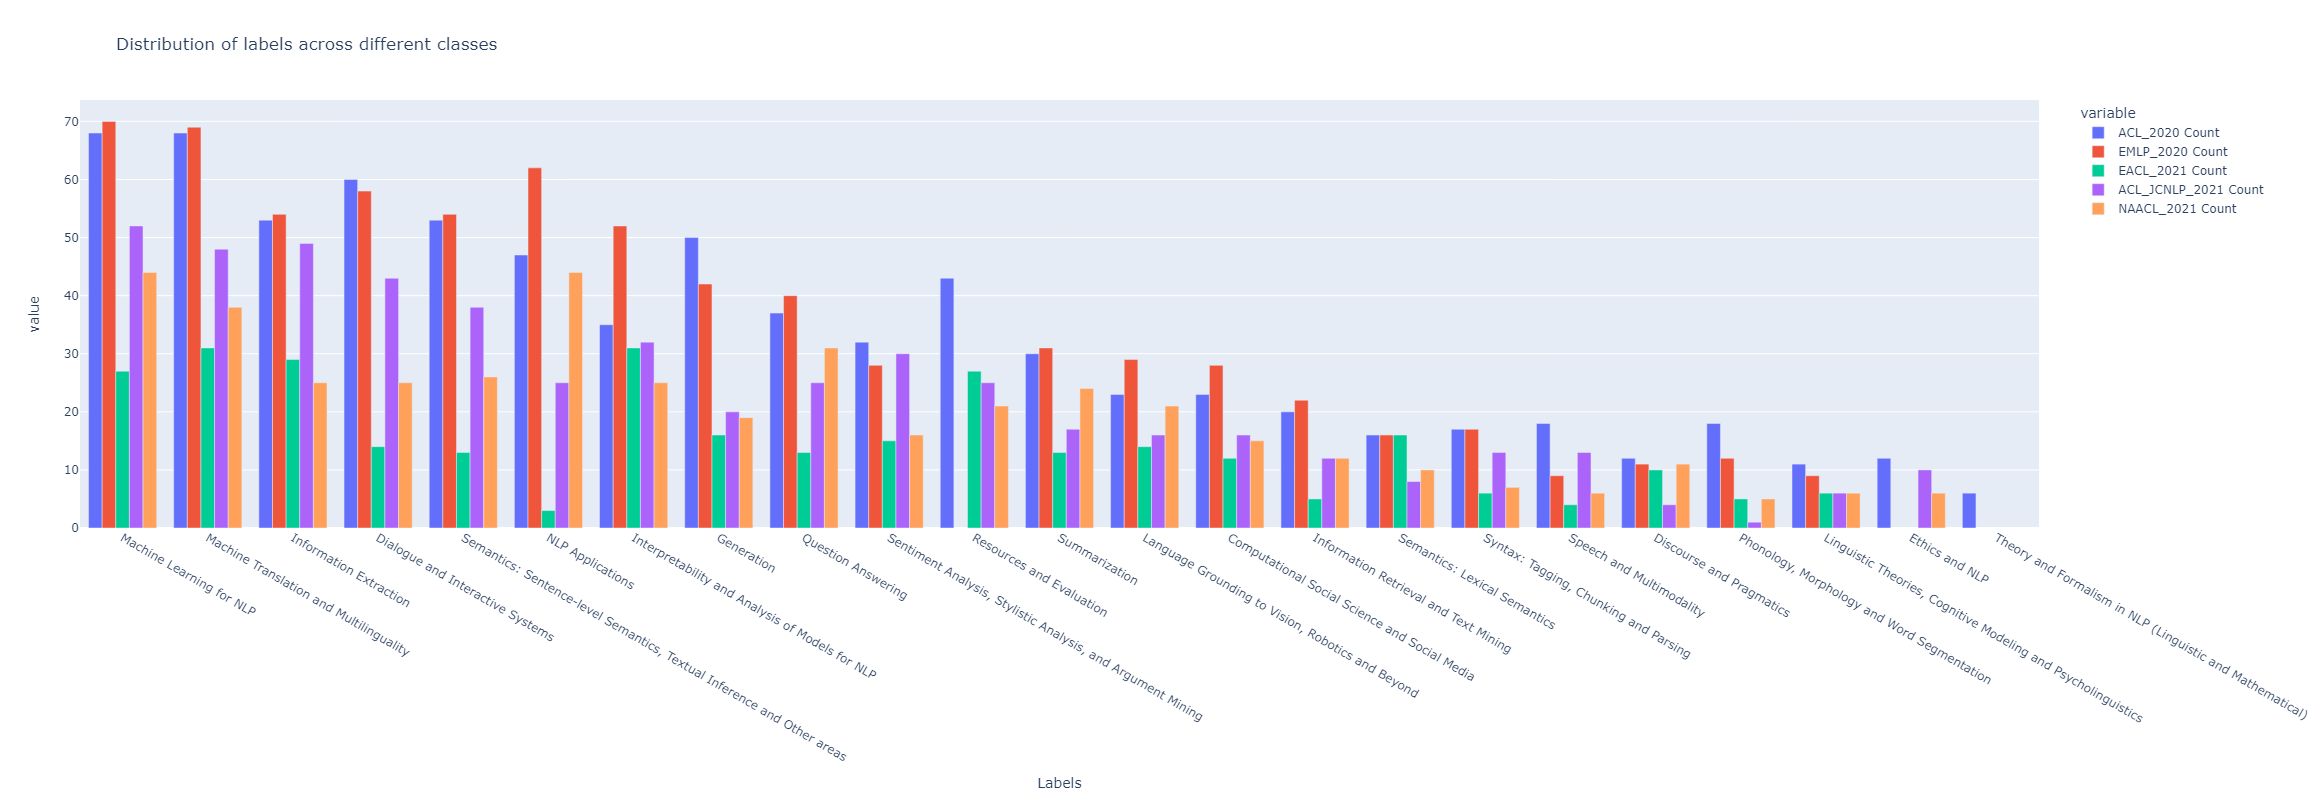

In [44]:
fig = px.bar(df_count, x="Labels", y=["ACL_2020 Count", "EMLP_2020 Count", "EACL_2021 Count", "ACL_JCNLP_2021 Count", "NAACL_2021 Count"], title="Distribution of labels across different classes", barmode='group',
             width=1600, height=800).update_xaxes(categoryorder = "total descending")
fig.show()

In [45]:
df_count_total = df_count.fillna(0)

In [46]:
df_count_total["Total"] = df_count_total.sum(axis = 1)

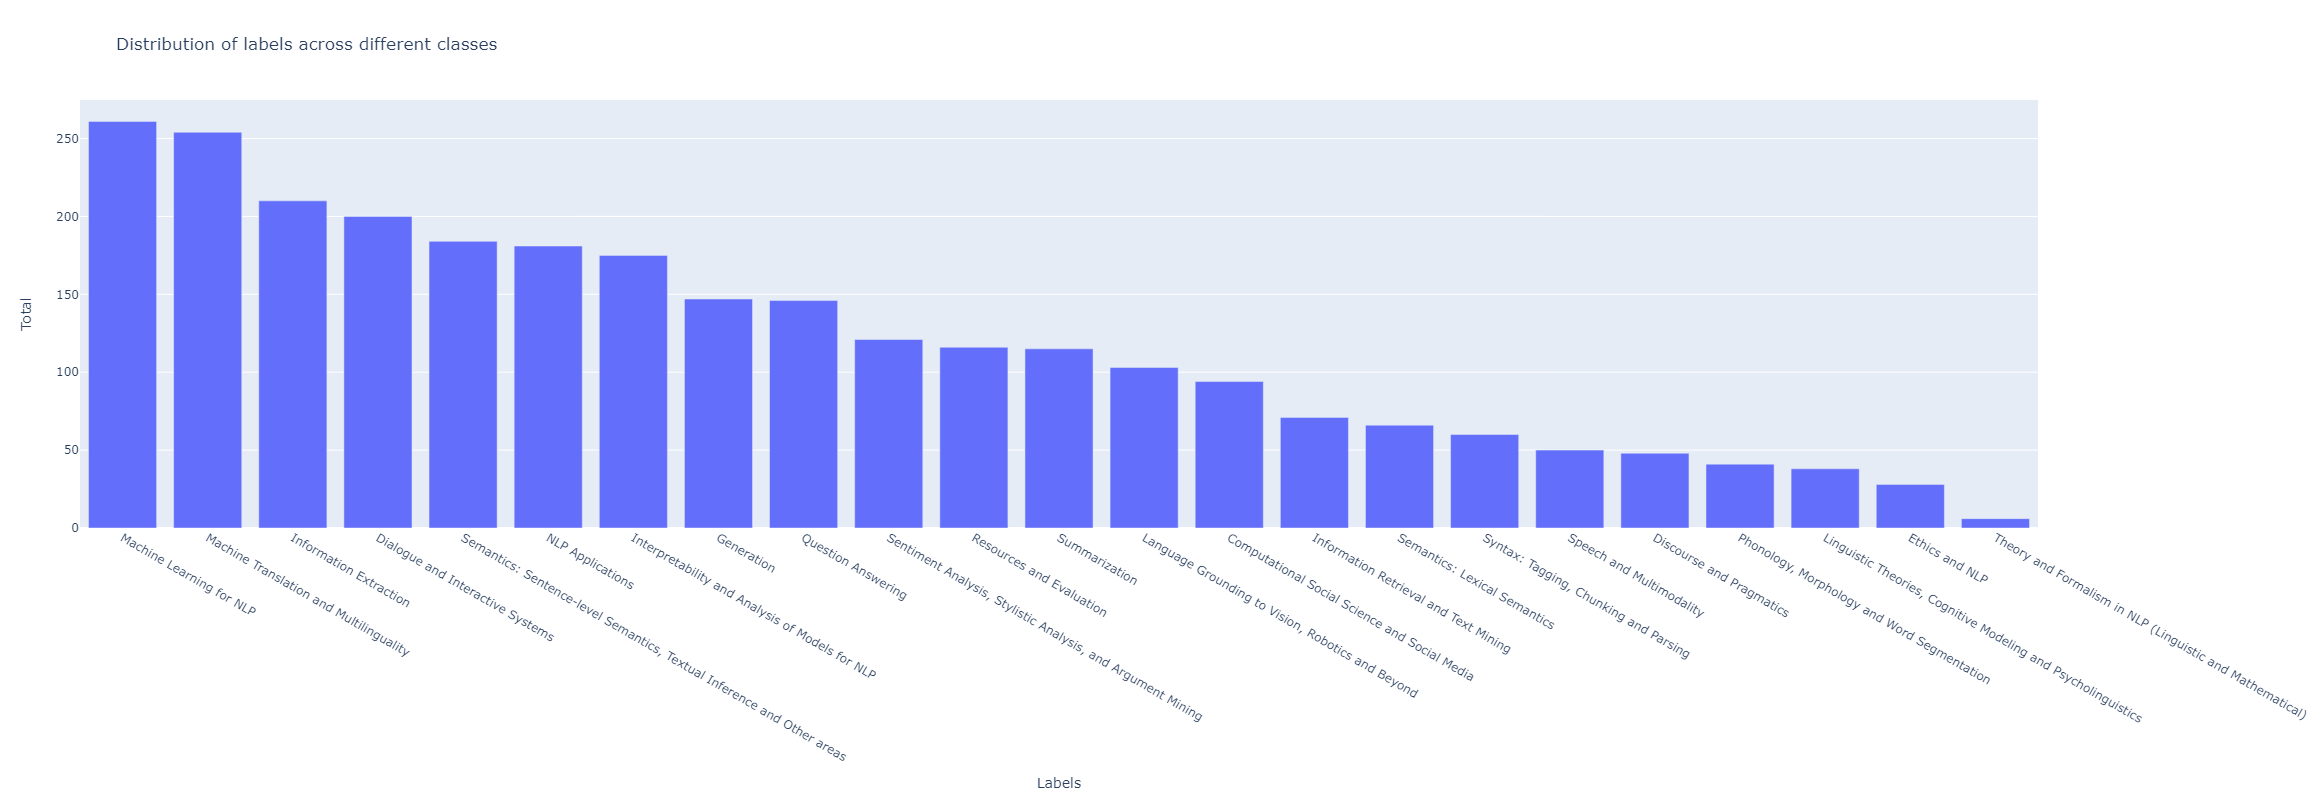

In [47]:
fig = px.bar(df_count_total, x="Labels", y="Total", title="Distribution of labels across different classes", barmode='group',
             width=1600, height=800).update_xaxes(categoryorder = "total descending")
fig.show()

In [48]:
df_count_total

,Labels,ACL_2020 Count,EMLP_2020 Count,EACL_2021 Count,ACL_JCNLP_2021 Count,NAACL_2021 Count,Total
0,Computational Social Science and Social Media,23,28.0,12.0,16.0,15.0,94.0
1,Dialogue and Interactive Systems,60,58.0,14.0,43.0,25.0,200.0
2,Discourse and Pragmatics,12,11.0,10.0,4.0,11.0,48.0
3,Ethics and NLP,12,0.0,0.0,10.0,6.0,28.0
4,Generation,50,42.0,16.0,20.0,19.0,147.0
5,Information Extraction,53,54.0,29.0,49.0,25.0,210.0
6,Information Retrieval and Text Mining,20,22.0,5.0,12.0,12.0,71.0
7,Interpretability and Analysis of Models for NLP,35,52.0,31.0,32.0,25.0,175.0
8,"Language Grounding to Vision, Robotics and Beyond",23,29.0,14.0,16.0,21.0,103.0
9,"Linguistic Theories, Cognitive Modeling and Ps...",11,9.0,6.0,6.0,6.0,38.0


### Looking at full text

Some text like the one below has alot more information than just the abstract, should check to see how the abstract was created. The text below seems to take text from figures as well.

In [49]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.contains('Being able to perform in-depth chat with humans in a closed domain')]

,Labels,Paper Name,abstract
65,Dialogue and Interactive Systems,MovieChats: Chat like Humans in a Closed Domain,Being able to perform in-depth chat with human...


Some text like the one below has phrases that are missing spaces, which might cause the text to become uncleaned. Will see how we can fix that at a later date

In [50]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.contains('minimallysupervise')]

,Labels,Paper Name,abstract
27,Computational Social Science and Social Media,Weakly Supervised Learning of Nuanced Frames f...,"In this paper, we suggest a minimallysupervise..."


### Looking at zero shot classifer (bart-large-mnli)

In [51]:
df_ACL_2020['Data from'] = "ACL_2020" 
df_EMNLP_2020['Data from'] = "EMNLP_2020" 
df_EACL_2021['Data from'] = "EACL_2021"
df_ACL_JCNLP_2021['Data from'] = "ACL_JCNLP_2021" 
df_NAACL_2021['Data from'] = "NAACL_2021"

In [52]:
df = pd.concat([df_ACL_2020, df_EMNLP_2020, df_EACL_2021, df_ACL_JCNLP_2021, df_NAACL_2021])

In [53]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli", 
                      device  = 0)

In [54]:
def classify_bart_large_mnli_labels(row):
    
    candidate_labels = list(df['Labels'].unique())
    
    sequence_to_classify = row['abstract']
    actual_label = row['Labels']
    
    out = classifier(sequence_to_classify, candidate_labels)
    prob_score = out['scores']
    labels = out['labels']
    
    # Returns the score of the actual label
    idx = labels.index(actual_label)
    label_score = prob_score[idx]
    
    return out, prob_score[0], labels[0], label_score

In [55]:
df_results = df.progress_apply(lambda x: pd.Series(classify_bart_large_mnli_labels(x), index=['Full Prediction', 'Max Score', 'Max Label', 'Actual Label Score']), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 2715/2715 [40:44<00:00,  1.11it/s]


In [58]:
df = pd.concat([df, df_results], axis = 1)

In [69]:
df_results

,Full Prediction,Max Score,Max Label,Actual Label Score
0,{'sequence': 'Can artificial neural networks l...,0.142634,Question Answering,0.035235
1,{'sequence': 'Speech directed to children diff...,0.237065,Information Extraction,0.032157
2,{'sequence': 'A standard approach to evaluatin...,0.139444,Generation,0.036095
3,{'sequence': 'Predicting reading time has been...,0.083154,Dialogue and Interactive Systems,0.039713
4,{'sequence': 'Despite the pervasiveness of cli...,0.085553,Dialogue and Interactive Systems,0.051511
...,...,...,...,...
471,{'sequence': 'Meetings are a key component of ...,0.181051,Summarization,0.181051
472,{'sequence': 'Multimodal summarization becomes...,0.315588,Question Answering,0.106065
473,{'sequence': 'This paper introduces MEDIASUM 1...,0.307898,Summarization,0.307898
474,{'sequence': 'Despite significant progress in ...,0.116928,Generation,0.099864


In [74]:
df_ACL_2020 = df[df['Data from'] == "ACL_2020"]
df_EMNLP_2020 = df[df['Data from'] == "EMNLP_2020"]
df_EACL_2021 = df[df['Data from'] == "EACL_2021"]
df_ACL_JCNLP_2021 = df[df['Data from'] == "ACL_JCNLP_2021"]
df_NAACL_2021 = df[df['Data from'] == "NAACL_2021"]


df_ACL_2020 = df_ACL_2020.drop(['Data from'], axis = 1)
df_EMNLP_2020 = df_EMNLP_2020.drop(['Data from'], axis = 1) 
df_EACL_2021 = df_EACL_2021.drop(['Data from'], axis = 1) 
df_ACL_JCNLP_2021 = df_ACL_JCNLP_2021.drop(['Data from'], axis = 1) 
df_NAACL_2021 = df_NAACL_2021.drop(['Data from'], axis = 1)

In [75]:
df_ACL_2020.to_csv("./Data/Pred/BART/ACL_2020_bart_pred_060123.csv", index = False)
df_EMNLP_2020.to_csv("./Data/Pred/BART/EMNLP_2020_bart_pred_060123.csv", index = False)
df_EACL_2021.to_csv("./Data/Pred/BART/EACL_2021_bart_pred_060123.csv", index = False)
df_ACL_JCNLP_2021.to_csv("./Data/Pred/BART/ACL_JCNLP_2021_bart_pred_060123.csv", index = False)
df_NAACL_2021.to_csv("./Data/Pred/BART/NAACL_2021_bart_pred_060123.csv", index = False)

In [29]:
df_ACL_2020 = pd.read_csv("./Data/Pred/BART/ACL_2022_bart_pred_231122.csv")
df_EMNLP_2020 = pd.read_csv("./Data/Pred/BART/EMNLP_2020_bart_pred_231122.csv")

### Prediction for datasets

In [76]:
idx_labels = list(df["Labels"].unique())

cm = confusion_matrix(df['Labels'], df['Max Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

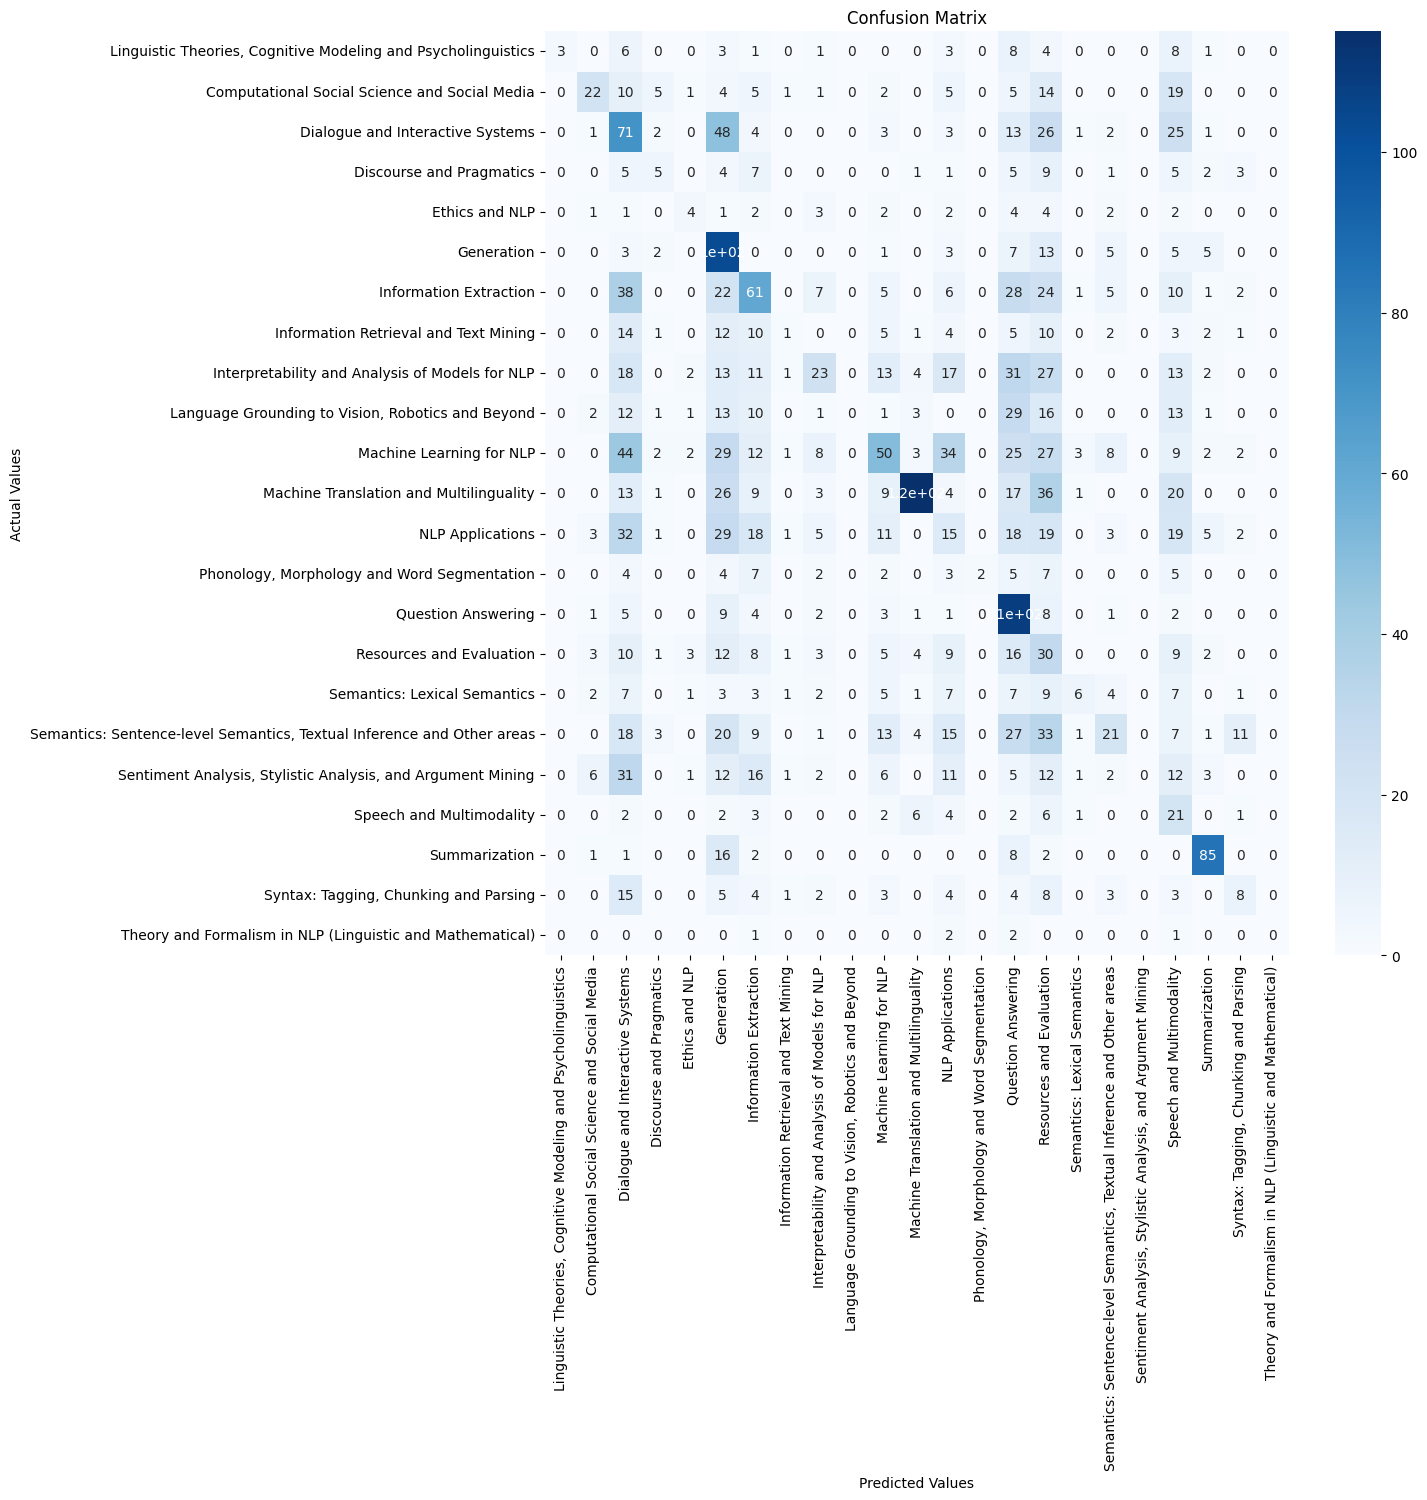

In [77]:
#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Classifcation results

In [78]:
print(classification_report(df['Labels'], df['Max Label']))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.52      0.23      0.32        94
                                      Dialogue and Interactive Systems       0.20      0.35      0.25       200
                                              Discourse and Pragmatics       0.21      0.10      0.14        48
                                                        Ethics and NLP       0.27      0.14      0.19        28
                                                            Generation       0.26      0.70      0.38       147
                                                Information Extraction       0.29      0.29      0.29       210
                                 Information Retrieval and Text Mining       0.11      0.01      0.03        71
                       Interpretability and Analysis of Models for NLP       0.35      0.13      0.19  

In [79]:
df["Label outcome"] = df.apply(lambda x: x["Labels"] == x["Max Label"], axis = 1)

In [80]:
df_outcome = df[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')

In [82]:
df_outcome = df_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])

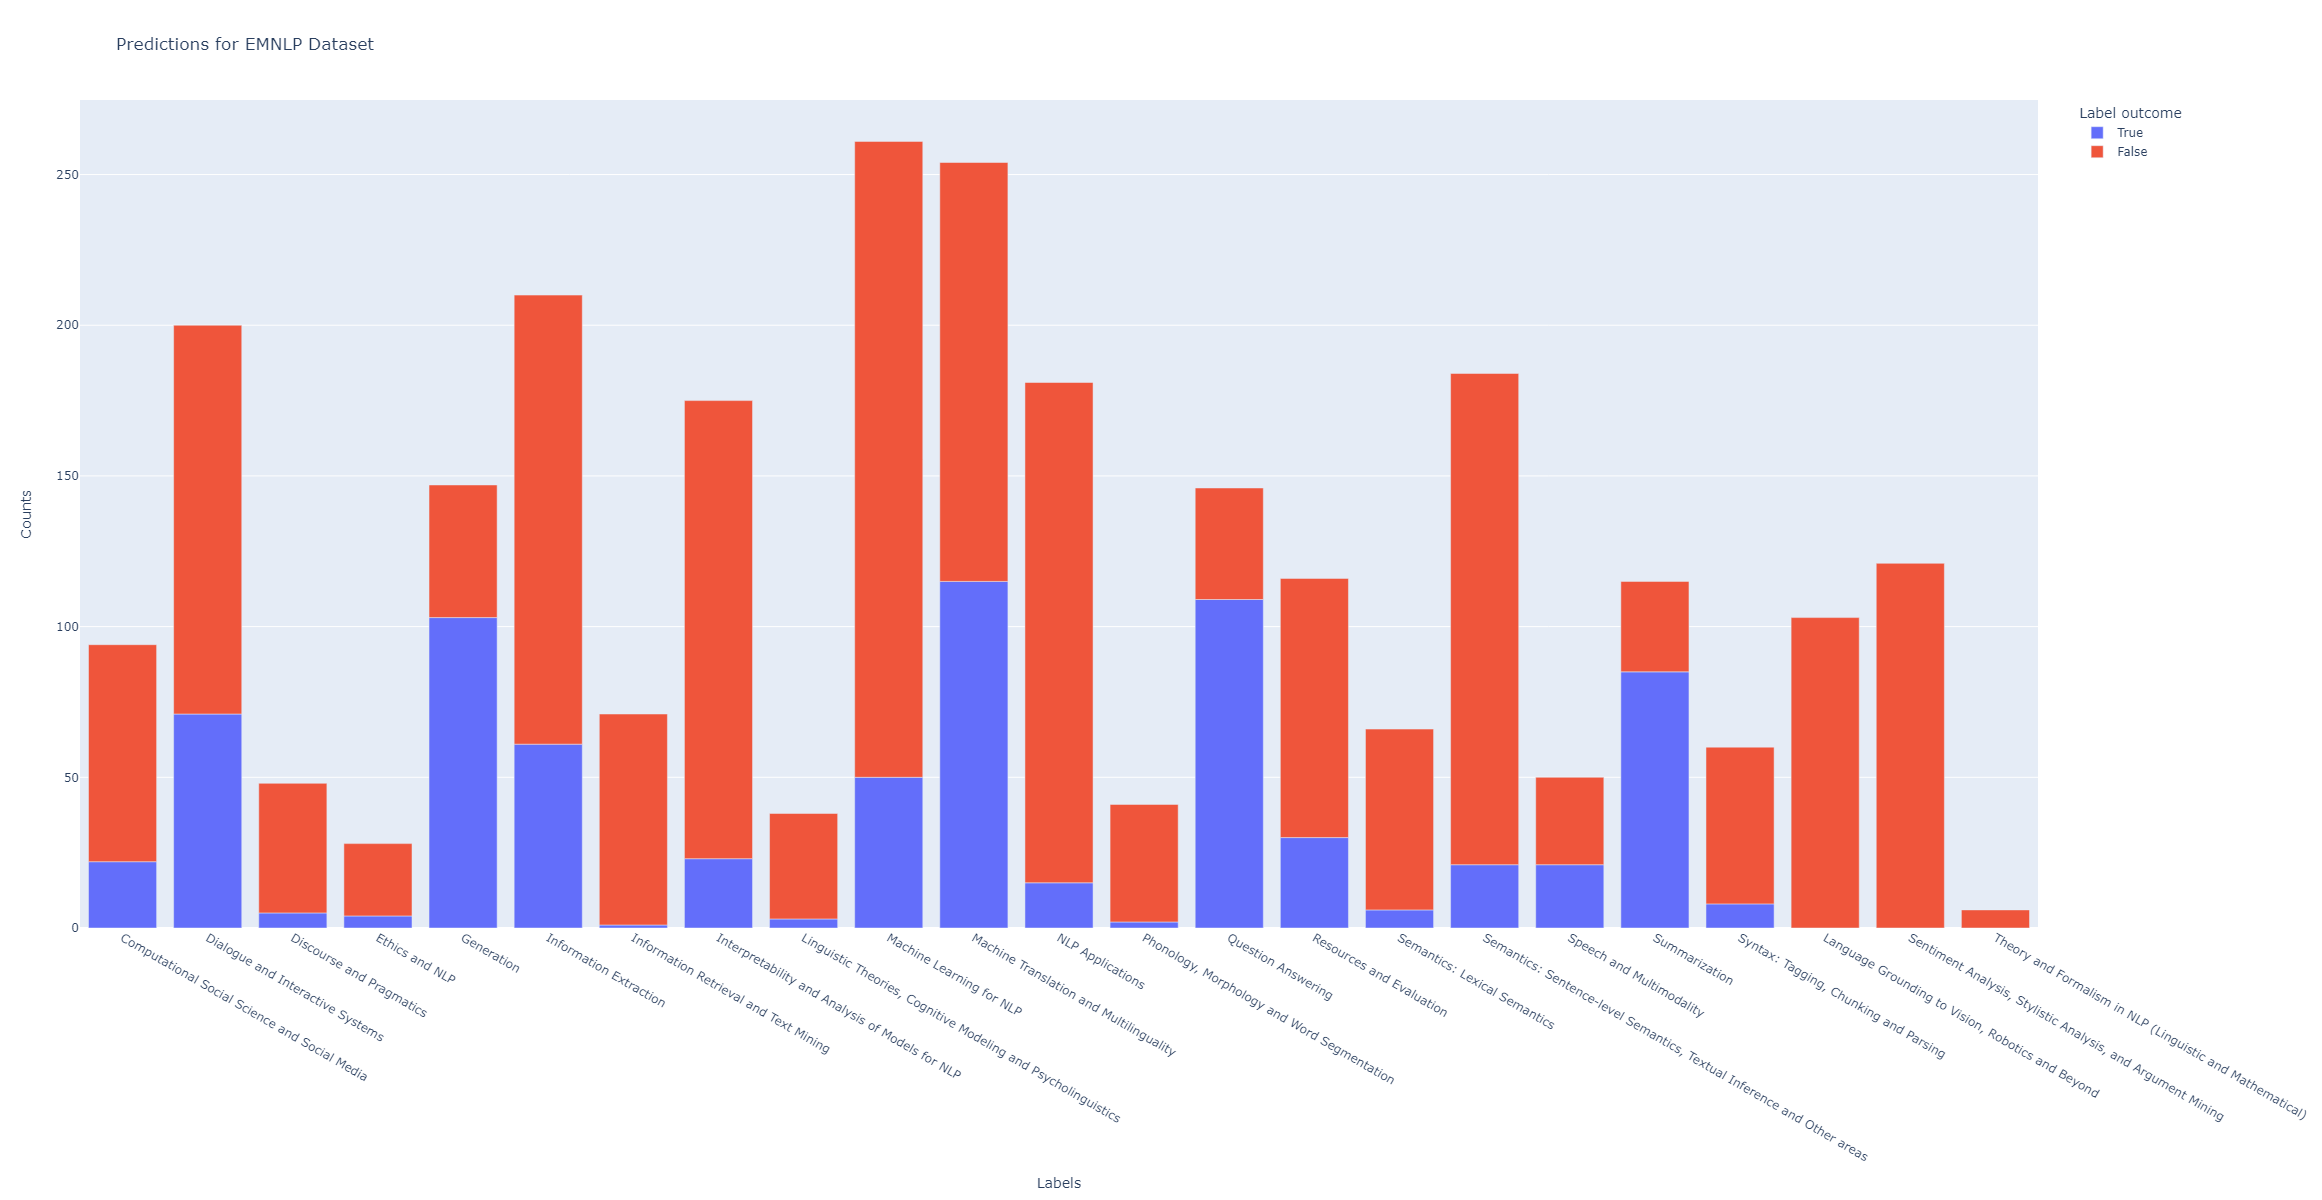

In [83]:
import plotly.express as px

fig = px.bar(df_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for EMNLP Dataset",
             width=1800, height=1200)
fig.show()

### Accuracy breakdown by Labels

#### Overall

In [84]:
df_accuracy = df_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)

In [85]:
df_accuracy["Accuracy"] = df_accuracy[True] / (df_accuracy[False] + df_accuracy[True]) * 100

In [86]:
df_accuracy = df_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_accuracy

Label outcome,Labels,False,True,Accuracy
14,Question Answering,37.0,109.0,74.657534
20,Summarization,30.0,85.0,73.913043
4,Generation,44.0,103.0,70.068027
11,Machine Translation and Multilinguality,139.0,115.0,45.275591
19,Speech and Multimodality,29.0,21.0,42.000000
1,Dialogue and Interactive Systems,129.0,71.0,35.500000
5,Information Extraction,149.0,61.0,29.047619
15,Resources and Evaluation,86.0,30.0,25.862069
0,Computational Social Science and Social Media,72.0,22.0,23.404255
10,Machine Learning for NLP,211.0,50.0,19.157088
